# Simulations de l'algorithme

### Fonctions de génération des communautés et des arêtes

In [2]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import sklearn.cluster as sk

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
## génération des communautés et calcul d'une arête entre deux sommets

def generateCommunities(n):
    community = [(0 if i<n//2 else 1) for i in range(n)]
    rd.shuffle(community)
    
    return community

def graph(i,j,community, p, q):
    if(rd.random()<p and community[i]==community[j]) or (rd.random()<q and community[i]!=community[j]):
        return 1
    else:
        return 0


### Algorithme spectral de détection de communautés.

On utilise ici l'algorithme de spectral clustering de sklearn.

Cet algorithme trouve les communautés en calculant les vecteurs propres de la matrice Laplacienne définie par :
$$L=I-D^{-1/2}RD^{-1/2}$$

où $D=\mathrm{diag}(d_1,\dots,d_n)$ avec $d_i$ le degré du sommet $i$

On considère les deux vecteurs propres associés aux deux **plus grandes valeurs propres** (en valeur absolue) de $L$: $X_1,X_2$

On traite alors $(X_1,X_2)$ comme une matrice de $\mathbb{R}^{n\times 2}$
On applique k-means aux $n$ lignes de la matrice, prises comme des points de $\mathbb{R}^{2}$.

Le cluster dans lequel un point est placé donne la communauté du sommet qui se trouve à la même ligne que lui.

In [4]:
def communityDetection(community, N, score, p, q):
    # score[0] représente le nombre de matchs effectués
    # score[1] représente le nombre de matchs réussis
    
    R=np.zeros((N,N))
    
    tau = 0
    R=np.zeros((N,N))
    for i in range(N):
        for j in range(i):
            R[i,j]=graph(i,j,community, p, q)
            tau += R[i,j]
            score[1] += R[i,j]
            R[j,i]=R[i,j]
    tau /= N*(N-1)//2
    score[0]+= N*(N-1)//2
    
    
    C1 = []
    C0 = []
        
    Community=sk.SpectralClustering(n_clusters=2, affinity='precomputed').fit(R).labels_
    
    for i in range(N):
        if(Community[i]==1):
            C1.append(i)
        else:
            C0.append(i)
    
    return(C0, C1, tau)

### Algorithme de matching pour la stratégie sans ajout de sommets.

In [5]:
## La stratégie est ici la même que celle décrite dans le rapport écrit

def matching(x, C0, C1, community, tau, score, T, p, q):
    mu0=graph(x, C0[0], community, p, q)
    mu1=graph(x, C1[0], community, p, q)    
    
    score[1] += mu0 + mu1
    
    s1 = 1
    s0 = 1
    score[0] += 2
    
    while(s0 < len(C0) and s1 < len(C1)):
        if(mu1 < s1*tau and mu0 < s0*tau):
            e1=graph(x, C1[s1], community, p, q)
            e0=graph(x, C0[s0], community, p ,q)
            
            mu1 += e1
            mu0 += e0
            score[1] += e1+e0
            
            s1 += 1
            s0 += 1
            score[0]+=2
        elif(mu1*s0 < mu0*s1):
            e0=graph(x, C0[s0], community, p, q)
            
            mu0 += e0
            score[1] += e0
            
            s0 += 1
            score[0] += 1
        else:
            e1=graph(x, C1[s1], community, p, q)
            
            mu1 += e1
            score[1] += e1
            
            s1 += 1
            score[0] += 1
        if(score[0]>=T):
            return

def naiveStrategy(community, T, p, q):
    N = min(int(((p*T)/(p-q)**2)**(1/3)), int((2*T)**(1/2)))
    score = [0,0]
    (C0, C1, tau) = communityDetection(community, N, score, p, q)
    
    x=N
    
    while(score[0]<T):
        matching(x, C0, C1, community, tau, score, T, p, q)
        x+=1
    return score[1]


### Algorithme de matching pour la stratégie avec ajout de sommets.

In [6]:
def matchingAdd(x, C0, C1, community, tau, score, T, p, q):
    mu0=graph(x, C0[0], community, p, q)
    mu1=graph(x, C1[0], community, p, q)    
    
    score[1] += mu0 + mu1
    
    s1 = 1
    s0 = 1
    score[0] += 2
    
    while(s0 < len(C0) and s1 < len(C1)):
        if(mu1 < s1*tau and mu0 < s0*tau):
            e1=graph(x, C1[s1], community, p, q)
            e0=graph(x, C0[s0], community, p ,q)
            
            mu1 += e1
            mu0 += e0
            score[1] += e1+e0
            
            s1 += 1
            s0 += 1
            score[0]+=2
        elif(mu1*s0 < mu0*s1):
            e0=graph(x, C0[s0], community, p, q)
            
            mu0 += e0
            score[1] += e0
            
            s0 += 1
            score[0] += 1
        else:
            e1=graph(x, C1[s1], community, p, q)
            
            mu1 += e1
            score[1] += e1
            
            s1 += 1
            score[0] += 1
        if(score[0]>=T):
            return
    
    if(s0 == len(C0)):
        C0.append(x)
    else:
        C1.append(x)

def addStrategy(community, T, p, q):
    N = int((T**(1/4)))
    score = [0,0]
    (C0, C1, tau) = communityDetection(community, N, score, p, q)
    
    x=N
    
    while(score[0]<T):
        matchingAdd(x, C0, C1, community, tau, score, T, p, q)
        x+=1
    return score[1]


### Simulations numériques des méthodes avec et sans ajout des sommets pour $p=0.5$ et $q=0.1$.

On utilise une échelle $\log/\log$ afin d'observer le comportement **sous-linéaire** des résultats.

In [7]:
p=1
q=0.5

logT=range(3,7)
T=[10**l for l in logT]

# résultat attendu en tirant des arêtes au hasard
RandomRegret=[(p-q)*t/2 for t in T]
logRandomRegret=np.log10(RandomRegret)

In [8]:
def testNaive(T, p, q):
    community=generateCommunities(T)
    
    return(naiveStrategy(community, T, p, q))

RegretNaive=[np.mean([(p*t)-testNaive(t,p,q) for i in range(5)]) for t in T]
logRegretNaive=np.log10(RegretNaive)

In [9]:
def testAdd(T, p, q):
    community=generateCommunities(int(T**(2/3)))
    
    return(addStrategy(community, T, p, q))

RegretAdd=[np.mean([(p*t)-testAdd(t,p,q) for i in range(5)]) for t in T]
logRegretAdd=np.log10(RegretAdd)

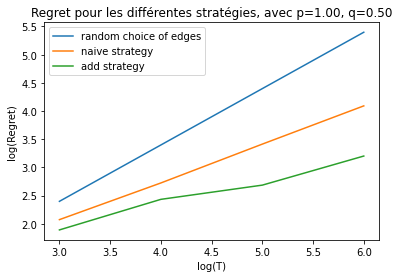

La pente pour la stratégie sans ajout des sommets vaut:
0.6727623739538324
La pente pour la stratégie avec ajout des sommets vaut:
0.4368968608856309


In [10]:
plt.plot(logT, logRandomRegret)
plt.plot(logT, logRegretNaive)
plt.plot(logT, logRegretAdd)

titre = 'Regret pour les différentes stratégies, avec p={P:.2f}, q={Q:.2f}'

plt.title(titre.format(P = p, Q = q))
plt.legend(['random choice of edges','naive strategy','add strategy'])
plt.xlabel('log(T)')
plt.ylabel('log(Regret)')

plt.show()

print('La pente pour la stratégie sans ajout des sommets vaut:')
print((logRegretNaive[-1]-logRegretNaive[0])/(logT[-1]-logT[0]))

print('La pente pour la stratégie avec ajout des sommets vaut:')
print((logRegretAdd[-1]-logRegretAdd[0])/(logT[-1]-logT[0]))

In [11]:
p=.95
q=0.2
T=10**6

alpha=[2**(-t) for t in range(7)]
logAlpha=np.log10(alpha)

RandomRegret=[a*T/2 for a in alpha]
logRandomRegret=np.log10(RandomRegret)

RegretNaive=[np.mean([(p*T)-testNaive(T,p,p-a) for i in range(10)]) for a in alpha]
logRegretNaive=np.log10(RegretNaive)

RegretAdd=[np.mean([(p*T)-testAdd(T,p,p-a) for i in range(10)]) for a in alpha]
logRegretAdd=np.log10(RegretAdd)


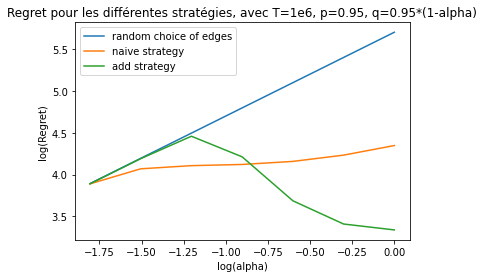

La pente pour la stratégie sans ajout des sommets vaut:
0.380503526557688
La pente pour la stratégie avec ajout des sommets vaut:
-0.23378523070092003


In [12]:
plt.plot(logAlpha, logRandomRegret)
plt.plot(logAlpha, logRegretNaive)
plt.plot(logAlpha, logRegretAdd)

titre = 'Regret pour les différentes stratégies, avec T=1e6, p=0.95, q=0.95*(1-alpha)'

plt.title(titre.format(P = p, Q = q))
plt.legend(['random choice of edges','naive strategy','add strategy'])
plt.xlabel('log(alpha)')
plt.ylabel('log(Regret)')

plt.show()

print('La pente pour la stratégie sans ajout des sommets vaut:')
print((logRegretNaive[0]-logRegretNaive[1])/(logAlpha[0]-logAlpha[1]))

print('La pente pour la stratégie avec ajout des sommets vaut:')
print((logRegretAdd[0]-logRegretAdd[1])/(logAlpha[0]-logAlpha[1]))

In [13]:
p=.95
q=.05
T=10**6

alpha=[2**(-t) for t in range(7)]
logAlpha=np.log10(alpha)

RandomRegret=[a*T/2 for a in alpha]
logRandomRegret=np.log10(RandomRegret)

RegretNaive=[np.mean([(a*p*T)-testNaive(T,a*p,a*q) for i in range(10)]) for a in alpha]
logRegretNaive=np.log10(RegretNaive)

RegretAdd=[np.mean([(a*p*T)-testAdd(T,a*p,a*q) for i in range(10)]) for a in alpha]
logRegretAdd=np.log10(RegretAdd)

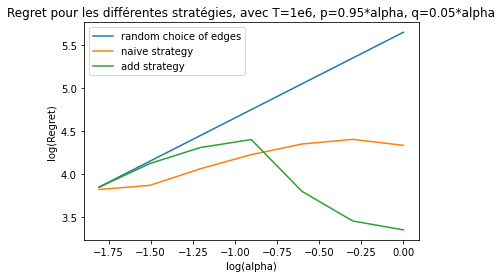

La pente pour la stratégie sans ajout des sommets vaut:
-0.23220825351805116
La pente pour la stratégie avec ajout des sommets vaut:
-0.34673620535105454


In [14]:
RandomRegret=[a*(.9)*T/2 for a in alpha]
logRandomRegret=np.log10(RandomRegret)

plt.plot(logAlpha, logRandomRegret)
plt.plot(logAlpha, logRegretNaive)
plt.plot(logAlpha, logRegretAdd)

titre = 'Regret pour les différentes stratégies, avec T=1e6, p=0.95*alpha, q=0.05*alpha'

plt.title(titre.format(caca = p, prout = q))
plt.legend(['random choice of edges','naive strategy','add strategy'])
plt.xlabel('log(alpha)')
plt.ylabel('log(Regret)')

plt.show()

print('La pente pour la stratégie sans ajout des sommets vaut:')
print((logRegretNaive[0]-logRegretNaive[1])/(logAlpha[0]-logAlpha[1]))

print('La pente pour la stratégie avec ajout des sommets vaut:')
print((logRegretAdd[0]-logRegretAdd[1])/(logAlpha[0]-logAlpha[1]))

## Résultats

### Stratégie avec ajout de sommets

On trouve une pente proche de 0.5 pour cette stratégie.
Cela concorde avec notre conjecture sur le regret en $O\left(\sqrt{T}\right)$ de la stratégie.

### Stratégie sans ajout de sommets

En ce qui concerne la stratégie sans ajout de sommets, on trouve une pente d'environ $0.74$, ce qui est assez proche des $\dfrac{2}{3}$ de nos résultats théoriques.

On retrouve donc bien le $O\left(T^{2/3}\right)$ de nos résultats théoriques.

Notons que notre deuxième algorithme semble atteindre son régime asymptotique plus rapidement que le premier.

# Simulations avec données réelles

On a choisi d'appliquer nos résultats sur un forum de discussion, dans la section politique.

On récupère les différents sujets (threads), ainsi que les utilisateurs ayant posté dessus.

In [9]:
import requests
import praw
from praw.models import MoreComments

import collections

r = praw.Reddit(username = 'Lucien-Arpene',            
password = 'Dissoutou1',            
client_id = 'DvuEtPu5GtwgN0oHsWBF0w',            
client_secret = 'tTdY5fyKK88YyE-_FSGBbQ22H6669w',            
user_agent = 'MyBot/0.0.1') 


In [10]:
def addAuthors(subredditName, authorsOfThread, limit):
    subreddit = r.subreddit(subredditName)
    if(limit==0):
        threads=subreddit.hot()
    else:
        threads=subreddit.hot(limit=limit)
    
    for thread in threads:
        comments=thread.comments
        comments.replace_more()

        authors=set(filter(lambda author:author!=None,[comment.author for comment in comments]))

        authorsOfThread[thread.title]=authors
    return authorsOfThread


def countComments(authorsOfThread):
    nbComments = {}
    
    for authors in authorsOfThread.values():
        for author in authors:
            if not(author in nbComments):
                nbComments[author]=1
            else:
                nbComments[author]+=1
    return nbComments

def cleanUp(nbComments, authorsOfThread):
    for author in nbComments.keys():
        if(nbComments[author]==1):
            for authors in authorsOfThread.values():
                authors.discard(author)

In [11]:
def generateData():
    authorsOfThread={}
    
    addAuthors('Politics',authorsOfThread, limit=100)

    nbComments=countComments(authorsOfThread)

    cleanUp(nbComments,authorsOfThread)

    authors = set([])

    for thread in authorsOfThread.values():
        for author in thread:
            authors.add(author)
    
    return(authorsOfThread, authors)


In [12]:
authorsOfThread, authors= generateData()

print("Il y a {} sommets sur le graphe".format(len(authors)))

Il y a 622 sommets sur le graphe


## Génération du graphe

On considère que deux utilisateurs du forum sont reliés s'ils ont écrit sur au moins un **thread commun**.

Cela pose un problème, puisque la majorité des utilisateurs n'ont écrit que sur un seul thread, ce qui rend les communautés triviales (une communauté ne serait qu'un ensemble de threads, avec les personnes associées).

On ne considère donc que les utilisateurs ayant écrit sur au moins **deux threads** différents, afin de rendre ce problème moins présent.

In [27]:
def edge(author1, author2, authorsOfThread):
    p=0
    
    for authorsSet in authorsOfThread.values():
        if(author1 in authorsSet and author2 in authorsSet):
            return 1
    return 0

def generateGraph(authorsOfThread, authors):
    authorsList = list(authors)
    rd.shuffle(authorsList)
    
    n=len(authorsList)
    graph=np.zeros((n,n), dtype=int)
    
    for i in range(n):
        for j in range(i):
            graph[i,j]=edge(authorsList[i],authorsList[j], authorsOfThread)
            graph[j,i]=graph[i,j]
    return graph
    

In [28]:
## Les programmse ci-dessous sont analogues à ceux de la partie précédente
## Cette fois-ci, le graphe est déjà généré

def communityDetectionGraph(graph, N, score):
    # score[0] représente le nombre de matchs effectués
    # score[1] représente le nombre de matchs réussis
    
    tau = 0
    for i in range(N):
        for j in range(i):
            tau += graph[i,j]
            score[1] += graph[i,j]
    tau /= N*(N-1)//2
    score[0]+= N*(N-1)//2
    
    R = [[graph[i,j] for j in range(N)] for i in range(N)]
    
    C1 = []
    C0 = []
    
    Community=sk.SpectralClustering(n_clusters=2, affinity='precomputed').fit(R).labels_
    
    for i in range(N):
        if(Community[i]==1):
            C1.append(i)
        else:
            C0.append(i)
    return(C0, C1, tau)

def naiveStrategyGraph(graph, T, p, q):
    N = min(int(((p*T)/(p-q)**2)**(1/3)), int((2*T)**(1/2)))
    score = [0, 0]
    (C0, C1, tau) = communityDetectionGraph(graph, N, score)
    
    x=N
    
    while(score[0]<T):
        matchingGraph(x, C0, C1, graph, tau, score, T)
        x+=1
    return score[1]

def matchingGraph(x, C0, C1, graph, tau, score, T):
    mu1 = graph[x,C1[0]]
    mu0 = graph[x,C0[0]]
    score[1] += graph[x,C1[0]] + graph[x,C0[0]]
    
    s1 = 1
    s0 = 1
    score[0] += 2
    
    while(s0 < len(C0) and s1 < len(C1)):
        if(mu1 < s1*tau and mu0 < s0*tau):
            mu1 += graph[x,C1[s1]]
            mu0 += graph[x,C0[s0]]
            score[1] += graph[x,C1[s1]] + graph[x,C0[s0]]
            
            s1 += 1
            s0 += 1
            score[0]+=2
        elif(mu1*s0 < mu0*s1):
            mu0 += graph[x,C0[s0]]
            score[1] += graph[x,C0[s0]]
            
            s0 += 1
            score[0] += 1
        else:
            mu1 += graph[x,C1[s1]]
            score[1] += graph[x,C1[s1]]
            
            s1 += 1
            score[0] += 1
        if(score[0]>=T):
            return


def matchingAddGraph(x, C0, C1, graph, tau, score, T):
    mu1 = graph[x][C1[0]]
    mu0 = graph[x][C0[0]]
    score[1] += graph[x,C1[0]] + graph[x,C0[0]]
    
    s1 = 1
    s0 = 1
    score[0] += 2
    
    while(s0 < len(C0) and s1 < len(C1)):
        if(mu1 < s1*tau and mu0 < s0*tau):
            mu1 += graph[x,C1[s1]]
            mu0 += graph[x,C0[s0]]
            score[1] += graph[x,C1[s1]] + graph[x,C0[s0]]
            
            s1 += 1
            s0 += 1
            score[0]+=2
        elif(mu1*s0 < mu0*s1):
            mu0 += graph[x,C0[s0]]
            score[1] += graph[x,C0[s0]]
            
            s0 += 1
            score[0] += 1
        else:
            mu1 += graph[x,C1[s1]]
            score[1] += graph[x,C1[s1]]
            
            s1 += 1
            score[0] += 1
        if(score[0]>=T):
            return
    
    if(s0 == len(C0)):
        C0.append(x)
    else:
        C1.append(x)

def addStrategyGraph(graph, T):
    N = int(T**(1/4))
    score = [0, 0]
    (C0, C1, tau) = communityDetectionGraph(graph, N, score)
    
    x=N
    
    while(score[0]<T):
        matchingAddGraph(x, C0, C1, graph, tau, score, T)
        x+=1
    return score[1]


### Estimation de p, q et tau sur l'ensemble des données

In [29]:
graph=generateGraph(authorsOfThread, authors)
(C1, C0, tau)=communityDetectionGraph(graph, len(authors), [0,0])

p=0

for i in C0:
    for j in C0:
        p+=graph[i,j]
for i in C1:
    for j in C1:
        p+=graph[i,j]

p/=len(C0)**2+len(C1)**2

q=0

for i in C1:
    for j in C0:
        q+=graph[i,j]
q/=len(C1)*len(C0)

print("On trouve p={}, q={}, tau={}".format(p,q,tau))

On trouve p=0.3157378450302053, q=0.06810344827586207, tau=0.20023196690329362


### Test des algorithmes sur les données

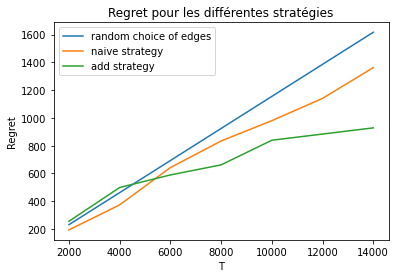

In [50]:
T=range(2000, len(authors)**2 // 25, 2000)

RandomRegret=[(p-tau)*t for t in T]
RegretNaive=[p*t-naiveStrategyGraph(graph,t,p,q) for t in T]
RegretAdd=[p*t-addStrategyGraph(graph,t) for t in T]

plt.plot(T,RandomRegret)
plt.plot(T, RegretNaive)
plt.plot(T, RegretAdd)

plt.title('Regret pour les différentes stratégies')
plt.legend(['random choice of edges','naive strategy','add strategy'])
plt.xlabel('T')
plt.ylabel('Regret')

plt.show()

## Résultats

On remarque que sur des faibles instances ($T<6000$), le programme avec ajout des arêtes est moins efficace que la version sans ajout des arêtes.

Cela s'explique par le fait que $6000^{1/4}<9$, ce qui rend le noyau trop petit pour que les communautés qui en émergent soient fiables.

Ces deux stratégies marchent bien mieux que le hasard.

Pour de faibles valeurs de $T$ on voit que la stratégie d'ajout est contre-productive.